# Lab 3: 

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib.ticker import PercentFormatter

import matplotlib.style as style

pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

import sqlalchemy
from sqlalchemy import create_engine

# SQL Basics

SQL, or Structured Query Language, is a tool to manipulate and retrieve data from databases. It is commonly used in industry to store, retrieve, and clean data used in a standard data science project. 

We will demonstrate some basics about fetching data from a SQL database in a common data science workflow.

In [72]:
# first we create a connection to the SQLite database we will use
engine = create_engine('sqlite://', echo=False)

# then we fetch data currently written as a CSV. Note, we could just read these data from CSV using pandas like we did in `live_lab02.ipynb`
df = pd.read_csv('../datasets/nutrition/Nutrition__Physical_Activity__and_Obesity_-_Behavioral_Risk_Factor_Surveillance_System.csv')
df = df[['YearStart', 'LocationDesc', 'Question', 'Data_Value', 'Education', 'Gender', 'Income', 'Race/Ethnicity', 'StratificationID1']]

# this stores the data as a SQL database within memory, so you will not see a new file added once you create this
df.to_sql(name='nutrition', con=engine, index=False)

53392

One of my favorite things about SQL is that it is typically very human readable, meaning the code we write _sounds_ simple, almost as if we were trying to describe the instructions in plain English.

For example:

```
select *
from nutrition
```

At the core of the query, we need to `select` data `from` a table. In this query, we are selecting `*`, which is a hotkey abbreviation that means "all". This query is read like "select all from nutrition". If a specific column is desired, we can replace the `*` and type in the column name.

The package `sqlalchemy` is a type of connector that helps us connect Python to a SQL database. We use the engine object to execute a SQL query, which allows us to retrieve data based on the SQL code.

In [73]:
data = engine.execute('select * from nutrition')
df = pd.DataFrame(data)
df.head()

,YearStart,LocationDesc,Question,Data_Value,Education,Gender,Income,Race/Ethnicity,StratificationID1
0,2011,Alabama,Percent of adults aged 18 years and older who have obesity,32.0,None,None,None,None,OVERALL
1,2011,Alabama,Percent of adults aged 18 years and older who have obesity,32.3,None,Male,None,None,MALE
2,2011,Alabama,Percent of adults aged 18 years and older who have obesity,31.8,None,Female,None,None,FEMALE
3,2011,Alabama,Percent of adults aged 18 years and older who have obesity,33.6,Less than high school,None,None,None,EDUHS
4,2011,Alabama,Percent of adults aged 18 years and older who have obesity,32.8,High school graduate,None,None,None,EDUHSGRAD


Other common SQL commands are `where` and `group by` statements. 

`where` statements allow us to add a filter to the query that only returns data when that filter condition is true. 

For example:

```
select *
from nutrition
where locationdesc = 'New Jersey'
```

This statement will grab all data from our nutrition table, if the `locationdesc` column is equal to 'Alabama'. Let's try it out.

In [129]:
# notice here we're using a trick in Python to let use the `\` symbol 
# to write code across multiple lines so that it's easier to read. 
sql = \
    '''
    select * 
    from nutrition
    where locationdesc = "New Jersey"
    '''

data = engine.execute(sql)
df = pd.DataFrame(data)
df.head()

,YearStart,LocationDesc,Question,Data_Value,Education,Gender,Income,Race/Ethnicity,StratificationID1
0,2011,New Jersey,Percent of adults aged 18 years and older who have obesity,23.7,None,None,None,None,OVERALL
1,2011,New Jersey,Percent of adults aged 18 years and older who have obesity,25.6,None,Male,None,None,MALE
2,2011,New Jersey,Percent of adults aged 18 years and older who have obesity,21.8,None,Female,None,None,FEMALE
3,2011,New Jersey,Percent of adults aged 18 years and older who have obesity,29.4,Less than high school,None,None,None,EDUHS
4,2011,New Jersey,Percent of adults aged 18 years and older who have obesity,26.9,High school graduate,None,None,None,EDUHSGRAD


In [132]:
# use for multiple regressors
pt = pd.pivot_table(data=df, index='YearStart', columns='Question', values='Data_Value', aggfunc='mean')
pt

Question,Percent of adults aged 18 years and older who have an overweight classification,Percent of adults aged 18 years and older who have obesity,Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination),Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic physical activity and engage in muscle-strengthening activities on 2 or more days a week,Percent of adults who achieve at least 300 minutes a week of moderate-intensity aerobic physical activity or 150 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination),Percent of adults who engage in muscle-strengthening activities on 2 or more days a week,Percent of adults who engage in no leisure-time physical activity,Percent of adults who report consuming fruit less than one time daily,Percent of adults who report consuming vegetables less than one time daily
YearStart,,,,,,,,,
2011,37.122222,23.774074,51.911538,22.757692,32.361538,31.503846,27.723077,34.419231,23.576923
2012,36.522222,24.429630,NaN,NaN,NaN,NaN,26.933333,NaN,NaN
2013,34.825926,27.344444,47.300000,20.437037,30.414815,31.700000,29.837037,35.562963,22.125926
2014,36.066667,27.014815,NaN,NaN,NaN,NaN,25.937037,NaN,NaN
2015,36.665385,26.500000,46.857692,19.876923,28.150000,31.142308,29.296296,36.350000,22.930769
2016,35.528000,28.100000,NaN,NaN,NaN,NaN,31.980000,NaN,NaN


In [126]:
# here we define a helper function to 
def get_data_from_question(question: str, 
                           engine: sqlalchemy.engine.base.Engine) -> pd.DataFrame:
    """
    Helper function to fetch data from the nutrition table given a query question

    Inputs:
    * `question`: a string object with the question to be queried
    * `engine` is a SQLAlchemy engine object with a connection to the SQLite database

    Returns a pandas DataFrame object with the response
    """

    # grab obesity data - f strings are used here to help automate the SQL query
    sql = \
        f'''
        select * 
        from nutrition
        where locationdesc = "National"
        and stratificationid1 = "OVERALL"
        and question = "{question}"

        order by yearstart asc
        '''

    data = engine.execute(sql)
    data = pd.DataFrame(data)

    return data

Text(0.5, 1.0, 'National Obesity Rates')

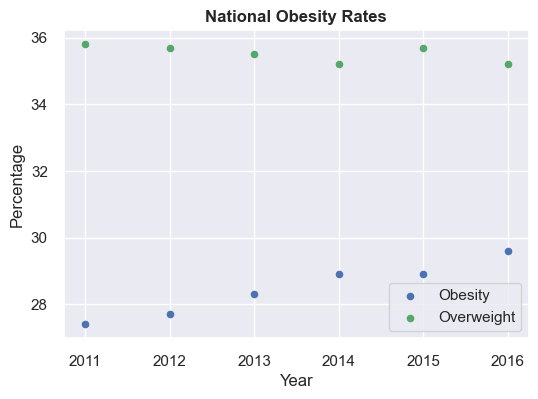

In [137]:
# grab obesity data
question = "Percent of adults aged 18 years and older who have obesity"
obesity = get_data_from_question(question=question, engine=engine)

# grab overweight data
question = "Percent of adults aged 18 years and older who have an overweight classification"
overweight = get_data_from_question(question=question, engine=engine)


# create a plot of the national obesity rates over time
fig, ax = plt.subplots(figsize=(6,4))
obesity.plot(x='YearStart', y='Data_Value', ax=ax, kind='scatter', label='Obesity')
overweight.plot(x='YearStart', y='Data_Value', ax=ax, kind='scatter', label='Overweight', color='g')

ax.set_xlabel('Year')
ax.set_ylabel('Percentage')
ax.set_title('National Obesity Rates', fontsize=12, weight='bold')


In [142]:
question = "Percent of adults aged 18 years and older who have obesity"
obesity = get_data_from_question(question=question, engine=engine)
obesity[['YearStart' ,'Data_Value']]

,YearStart,Data_Value
0,2011,27.4
1,2012,27.7
2,2013,28.3
3,2014,28.9
4,2015,28.9
5,2016,29.6


In [149]:
from sklearn.linear_model import LinearRegression

X=pd.DataFrame(obesity['YearStart'])
y = obesity['Data_Value']
reg = LinearRegression().fit(X=X, y=y)

In [150]:
reg.score(X, y)

0.9669642857142743

In [153]:
reg.coef_, reg.intercept_

(array([0.43428571]), -845.9676190476197)

In [157]:
future = pd.DataFrame({'YearStart': [2017, 2018, 2019]})
reg.predict(future)

array([29.98666667, 30.42095238, 30.8552381 ])

In [24]:
df['Question'].unique()

array(['Percent of adults aged 18 years and older who have obesity',
       'Percent of adults aged 18 years and older who have an overweight classification',
       'Percent of adults who report consuming fruit less than one time daily',
       'Percent of adults who report consuming vegetables less than one time daily',
       'Percent of adults who engage in muscle-strengthening activities on 2 or more days a week',
       'Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination)',
       'Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic physical activity and engage in muscle-strengthening activities on 2 or more days a week',
       'Percent of adults who achieve at least 300 minutes a week of moderate-intensity aerobic physical activity 

In [35]:
df['StratificationID1'].unique()

array(['OVERALL', 'MALE', 'FEMALE', 'EDUHS', 'EDUHSGRAD', 'EDUCOTEC',
       'EDUCOGRAD', 'AGEYR1824', 'AGEYR2534', 'AGEYR3544', 'AGEYR4554',
       'AGEYR5564', 'AGEYR65PLUS', 'INCLESS15', 'INC1525', 'INC2535',
       'INC3550', 'INC5075', 'INC75PLUS', 'INCNR', 'RACEWHT', 'RACEBLK',
       'RACEHIS', 'RACEASN', 'RACEHPI', 'RACENAA', 'RACE2PLUS', 'RACEOTH'],
      dtype=object)